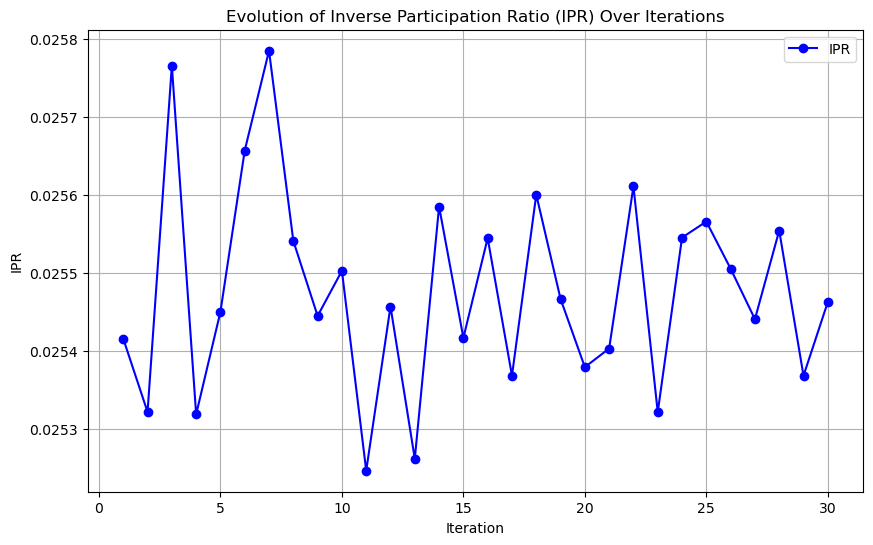

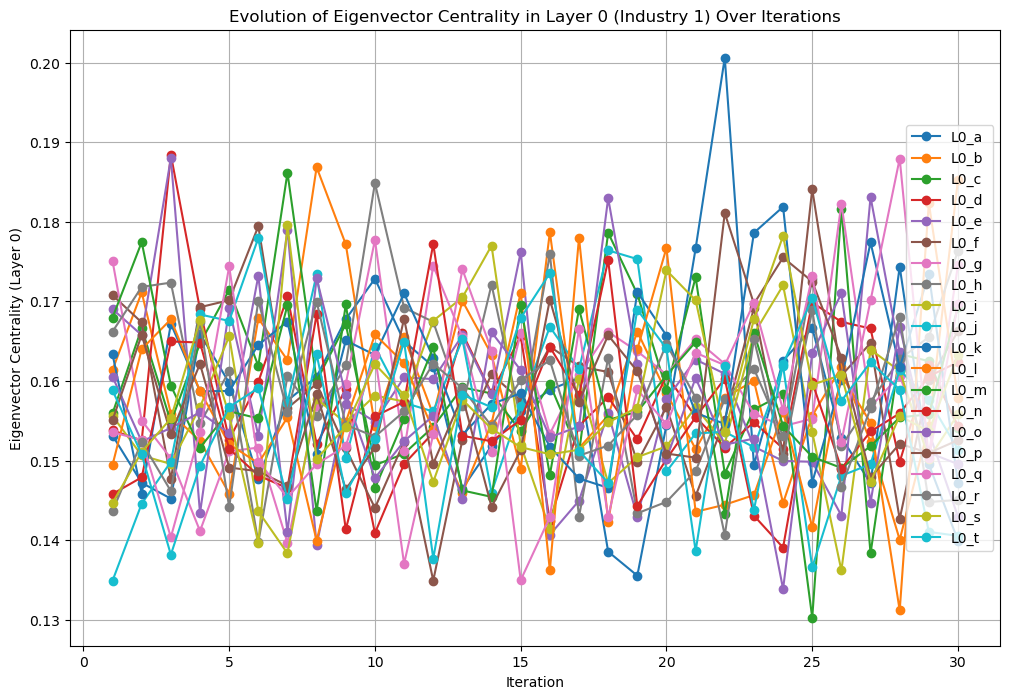

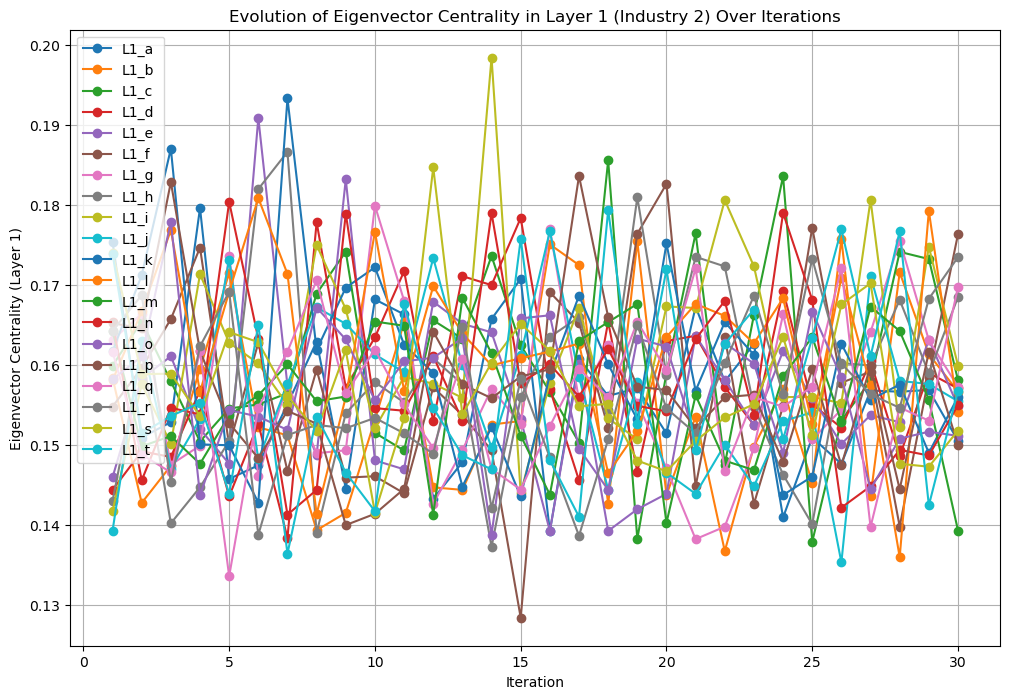


IPR DataFrame:
   Iteration       IPR
0          1  0.025415
1          2  0.025322
2          3  0.025766
3          4  0.025319
4          5  0.025450

Centrality DataFrame:
       L0_a      L0_b      L0_c      L0_d      L0_e      L0_f      L0_g  \
0  0.153142  0.161401  0.155920  0.153781  0.169021  0.170778  0.175063   
1  0.147198  0.171130  0.166646  0.152519  0.165765  0.167349  0.155014   
2  0.145208  0.155906  0.154814  0.188435  0.188003  0.147653  0.150271   
3  0.165930  0.152458  0.164728  0.168987  0.143384  0.169268  0.141142   
4  0.159760  0.145852  0.171437  0.152585  0.169121  0.170144  0.151149   

       L0_h      L0_i      L0_j  ...      L1_l      L1_m      L1_n      L1_o  \
0  0.166206  0.155589  0.134904  ...  0.158088  0.164242  0.165352  0.158188   
1  0.171819  0.150632  0.144576  ...  0.166697  0.149826  0.145561  0.161066   
2  0.172352  0.149566  0.149835  ...  0.176849  0.151100  0.154638  0.177912   
3  0.154675  0.156728  0.168355  ...  0.156620  0.14

In [7]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
import seaborn as sns

# For reproducibility
np.random.seed(42)

# Parameters for the multi-layer network
num_layers = 2        # Number of layers (industries)
nodes_per_layer = 20  # Number of nodes (countries) per layer
mu, sigma = 50, 10    # Mean and std deviation for edge weights (normal distribution)

# Function to create the random network, calculate eigenvector centrality and IPR
def create_network_and_calculate_metrics():
    G = nx.DiGraph()

    # Adding nodes and edges with weights based on normal distribution
    for layer in range(num_layers):
        # Add nodes to the graph with the new naming scheme (L0_a, L0_b, ...)
        for i in range(nodes_per_layer):
            node_label = f"L{layer}_{chr(97 + i)}"  # 'a' to 't' for nodes
            G.add_node(node_label, layer=layer)
        
        # Add random edges within the layer
        edges = nx.gnp_random_graph(nodes_per_layer, 0.05, directed=True)
        for u, v in edges.edges():
            weight = abs(np.random.normal(mu, sigma))  # Positive weights
            G.add_edge(f"L{layer}_{chr(97 + u)}", f"L{layer}_{chr(97 + v)}", weight=weight)
        
        # Randomly add self-directed edges (loops)
        self_loop_nodes = np.random.choice(range(nodes_per_layer), size=int(nodes_per_layer * 0.3), replace=False)  # 30% chance for self-loops
        for i in self_loop_nodes:
            weight = abs(np.random.normal(mu, sigma))
            G.add_edge(f"L{layer}_{chr(97 + i)}", f"L{layer}_{chr(97 + i)}", weight=weight)

        # Add random edges between layers (except for the last layer)
        if layer < num_layers - 1:
            for i in range(nodes_per_layer):
                for j in range(nodes_per_layer):
                    weight = abs(np.random.normal(mu, sigma))
                    G.add_edge(f"L{layer}_{chr(97 + i)}", f"L{layer+1}_{chr(97 + j)}", weight=weight)
                    G.add_edge(f"L{layer+1}_{chr(97 + j)}", f"L{layer}_{chr(97 + i)}", weight=weight)

    # Calculate eigenvector centrality
    eigen_centrality = nx.eigenvector_centrality_numpy(G, weight='weight')

    # Calculate IPR
    centrality_values = np.array(list(eigen_centrality.values()))
    ipr = np.sum(centrality_values**4)
    
    return eigen_centrality, ipr

# Repeat the network formation for multiple iterations (20-30 times)
num_iterations = 30
ipr_values = []
centrality_data = {}

for iteration in range(num_iterations):
    # Create the network and calculate metrics
    eigen_centrality, ipr = create_network_and_calculate_metrics()
    
    # Store IPR values
    ipr_values.append(ipr)
    
    # Store centrality values in the dictionary (for analysis later)
    for node, centrality in eigen_centrality.items():
        if node not in centrality_data:
            centrality_data[node] = []
        centrality_data[node].append(centrality)

# Create a DataFrame to store the results
ipr_df = pd.DataFrame({'Iteration': range(1, num_iterations + 1), 'IPR': ipr_values})

# Create a DataFrame for the centrality values
centrality_df = pd.DataFrame(centrality_data)
centrality_df['Iteration'] = range(1, num_iterations + 1)

# Plotting IPR evolution
plt.figure(figsize=(10, 6))
plt.plot(ipr_df['Iteration'], ipr_df['IPR'], marker='o', linestyle='-', color='b', label='IPR')
plt.xlabel('Iteration')
plt.ylabel('IPR')
plt.title('Evolution of Inverse Participation Ratio (IPR) Over Iterations')
plt.grid(True)
plt.legend()
plt.show()

# Plotting centrality evolution for Layer 0
plt.figure(figsize=(12, 8))
layer_0_nodes = [node for node in centrality_df.columns[:-1] if node.startswith("L0")]
for node in layer_0_nodes:
    plt.plot(centrality_df['Iteration'], centrality_df[node], marker='o', linestyle='-', label=node)

plt.xlabel('Iteration')
plt.ylabel('Eigenvector Centrality (Layer 0)')
plt.title('Evolution of Eigenvector Centrality in Layer 0 (Industry 1) Over Iterations')
plt.legend(loc='center right')
plt.grid(True)
plt.show()

# Plotting centrality evolution for Layer 1
plt.figure(figsize=(12, 8))
layer_1_nodes = [node for node in centrality_df.columns[:-1] if node.startswith("L1")]
for node in layer_1_nodes:
    plt.plot(centrality_df['Iteration'], centrality_df[node], marker='o', linestyle='-', label=node)

plt.xlabel('Iteration')
plt.ylabel('Eigenvector Centrality (Layer 1)')
plt.title('Evolution of Eigenvector Centrality in Layer 1 (Industry 2) Over Iterations')
plt.legend()
plt.grid(True)
plt.show()

# Display the resulting DataFrames
print("\nIPR DataFrame:")
print(ipr_df.head())

print("\nCentrality DataFrame:")
print(centrality_df.head())
